In [1]:
import casadi as ca
import numpy as np
import src.mpc_params as mpc_params
import src.mpc_casadi as mpc
from src.mpc_casadi import MPC_CBF

from time import time
from src.animation_code import simulate
from src.utils import gen_waypoints, gen_reference_trajectory
from src.taxiway_graph import TaxiwayGraph

Total time:  211.72154831886292
avg iteration time:  39.51622956718494 ms
Done


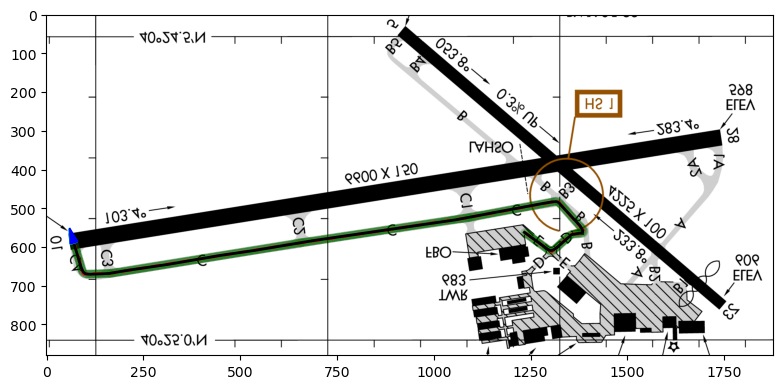

In [3]:
csv_file_path = r".\data\Position_of_Airport.csv"
image_path = r".\data\map.png"

# Create the TaxiwayGraph object
taxiway_graph = TaxiwayGraph(csv_file_path, image_path)

# Define the start and end gates
start_gate = 'Gate 2'
end_runway = 'R10L'

# Find the shortest path from the starting gate to the runway
shortest_path_flight, control_points = taxiway_graph.find_shortest_path_flight(start_gate, end_runway)

turning_radius = 5
turning_res = 10

waypoints = gen_waypoints(control_points, turning_radius, turning_res)

ref = gen_reference_trajectory(waypoints, mpc_params.v_target, mpc_params.dt)


x_init = ref[0,0]
y_init = ref[0,1]
theta_init = ref[0,2]
state_init = ca.DM([x_init, y_init, theta_init, 0, 0, 0])        # initial state

t0 = 0
t = ca.DM(t0)

Q_params = [mpc_params.Q_x, mpc_params.Q_y, mpc_params.Q_theta, mpc_params.Q_vx, mpc_params.Q_vx, mpc_params.Q_omega]
R_params = [mpc_params.R1, mpc_params.R2]
F_lims = [mpc_params.F_min, mpc_params.F_max]
tau_lims = [mpc_params.tau_min, mpc_params.tau_max]
v_lims = [mpc_params.v_min, mpc_params.v_max]
omega_lims = [mpc_params.omega_min, mpc_params.omega_max]

r = 1 # Safety radius
w = 10 # Runway radius
alpha = 10 # Parameter for scalar class-K function, must be positive

mpc_cbf = MPC_CBF(mpc_params.dt, mpc_params.v_target, 
                    Q_params, R_params, 
                    F_lims, tau_lims, v_lims, omega_lims,
                    mpc_params.N, mpc_params.mass, mpc_params.I0, 
                    r, w, alpha)

u0 = ca.DM.zeros((mpc_cbf.n_controls, mpc_params.N))      # initial control
X0 = ca.repmat(state_init, 1, mpc_params.N+1)         # initial state full

mpc_iter = 0
cat_states = mpc.DM2Arr(X0)
cat_controls = mpc.DM2Arr(u0[:, 0])
times = np.array([[0]])

main_loop = time()  # return time in sec
obstacles = None # This simulation assumes there are no obstacles; a simulation that incorporates an obstacle event will be developed later
for k in range(len(ref)):
    t1 = time()

    sol = mpc_cbf.get_solution(X0, u0, state_init, ref, k, obstacles)

    u = ca.reshape(sol['x'][mpc_cbf.n_states * (mpc_cbf.N + 1):], mpc_cbf.n_controls, mpc_cbf.N)
    X0 = ca.reshape(sol['x'][: mpc_cbf.n_states * (mpc_cbf.N + 1)], mpc_cbf.n_states, mpc_cbf.N+1)
    
    cat_states = np.dstack((
        cat_states,
        mpc.DM2Arr(X0)
    ))
    
    cat_controls = np.vstack((
        cat_controls,
        mpc.DM2Arr(u[:, 0])
    ))
    t = np.vstack((t,t0))

    t0, state_init, u0 = mpc.shift_timestep(mpc_params.dt, t0, state_init, u, mpc_cbf.f)

    X0 = ca.horzcat(
        X0[:, 1:],
        ca.reshape(X0[:, -1], -1, 1)
    )

    # xx ...
    t2 = time()
    times = np.vstack((
        times,
        t2-t1
    ))

    mpc_iter = mpc_iter + 1

main_loop_time = time()

print('Total time: ', main_loop_time - main_loop)
print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')

# simulate
x_target, y_target = ref[-1, 0], ref[-1, 1]
theta_target = np.arctan2(ref[-1, 1] - ref[-2,1], ref[-1, 0] - ref[-2,0])
simulate(ref, cat_states, cat_controls, times, mpc_params.dt, mpc_params.N, w,
            np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), image_path, save=True)
print('Done')